<a href="https://colab.research.google.com/github/yootaka/AiQuest/blob/main/carfuel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#車の走行距離
#ライブラリーのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
# Google ドライブをマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = "/content/drive/My Drive/Colab Notebooks/CarFuel"


In [54]:
#csvファイルの読み込み
csv_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CarFuel/train.csv', sep=",",engine="python")
csv_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CarFuel/test.csv', sep=",",engine="python")

In [55]:
print(csv_train.shape)
print(csv_test.shape)

(500, 10)
(500, 9)


In [56]:
csv_train.head(10)

,id,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,0,23.059782,6,140,110,2815,17.977429,80,1,dodge aspen
1,3,17.674521,8,350,150,4456,13.514535,72,1,dodge rampage
2,4,17.136353,8,302,140,2774,13.209912,79,1,mercury cougar brougham
3,7,22.664666,6,400,85,2190,15.196381,71,1,pontiac j2000 se hatchback
4,9,17.872018,8,429,220,2245,9.621400,70,1,ford galaxie 500
5,11,23.405007,6,140,110,2815,18.152362,80,1,dodge aspen
6,13,17.250298,6,318,110,3205,19.228868,75,1,vw rabbit custom
7,16,35.469676,4,140,165,2145,13.519583,82,1,amc gremlin
8,19,22.839820,6,200,85,3193,17.215803,71,1,dodge monaco brougham
9,23,36.489563,4,104,60,2000,14.899884,81,1,datsun 200sx


In [57]:
#年式の最大値　行
print(csv_train['model year'].idxmax())

7


In [58]:
#年式の最大値
print(csv_train.iat[csv_train['model year'].idxmax(), 7])

82


In [59]:
#年式の最小値
print(csv_train.iat[csv_train['model year'].idxmin(), 7])

70


In [60]:
#欠損値の確認　null値はないがhorsepower=?あり
csv_train.isnull().any(axis=0)

id              False
mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
model year      False
origin          False
car name        False
dtype: bool

In [61]:
#統計量計算
csv_train.describe()

,id,mpg,cylinders,displacement,weight,acceleration,model year,origin
count,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.000000
mean,500.176000,27.010940,5.192000,194.762000,2719.71400,15.300328,76.332000,1.420000
std,288.657179,7.356249,1.617519,106.277425,717.03541,2.261096,3.909007,0.759443
min,0.000000,15.787613,4.000000,79.000000,1755.00000,9.530859,70.000000,1.000000
25%,242.250000,22.396641,4.000000,104.000000,2178.75000,13.441562,73.000000,1.000000
50%,513.000000,26.228984,4.000000,140.000000,2615.00000,15.231923,76.000000,1.000000
75%,750.250000,35.088333,6.000000,302.000000,3193.00000,17.190531,80.000000,2.000000
max,997.000000,44.763897,8.000000,429.000000,4732.00000,21.922511,82.000000,3.000000


<function matplotlib.pyplot.show>

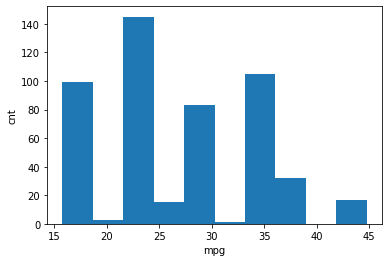

In [62]:
#mpgの分布 mile par gallon 　　　　40mile以上は無視するか？
plt.hist(csv_train['mpg'])
plt.xlabel('mpg')
plt.ylabel('cnt')
plt.show

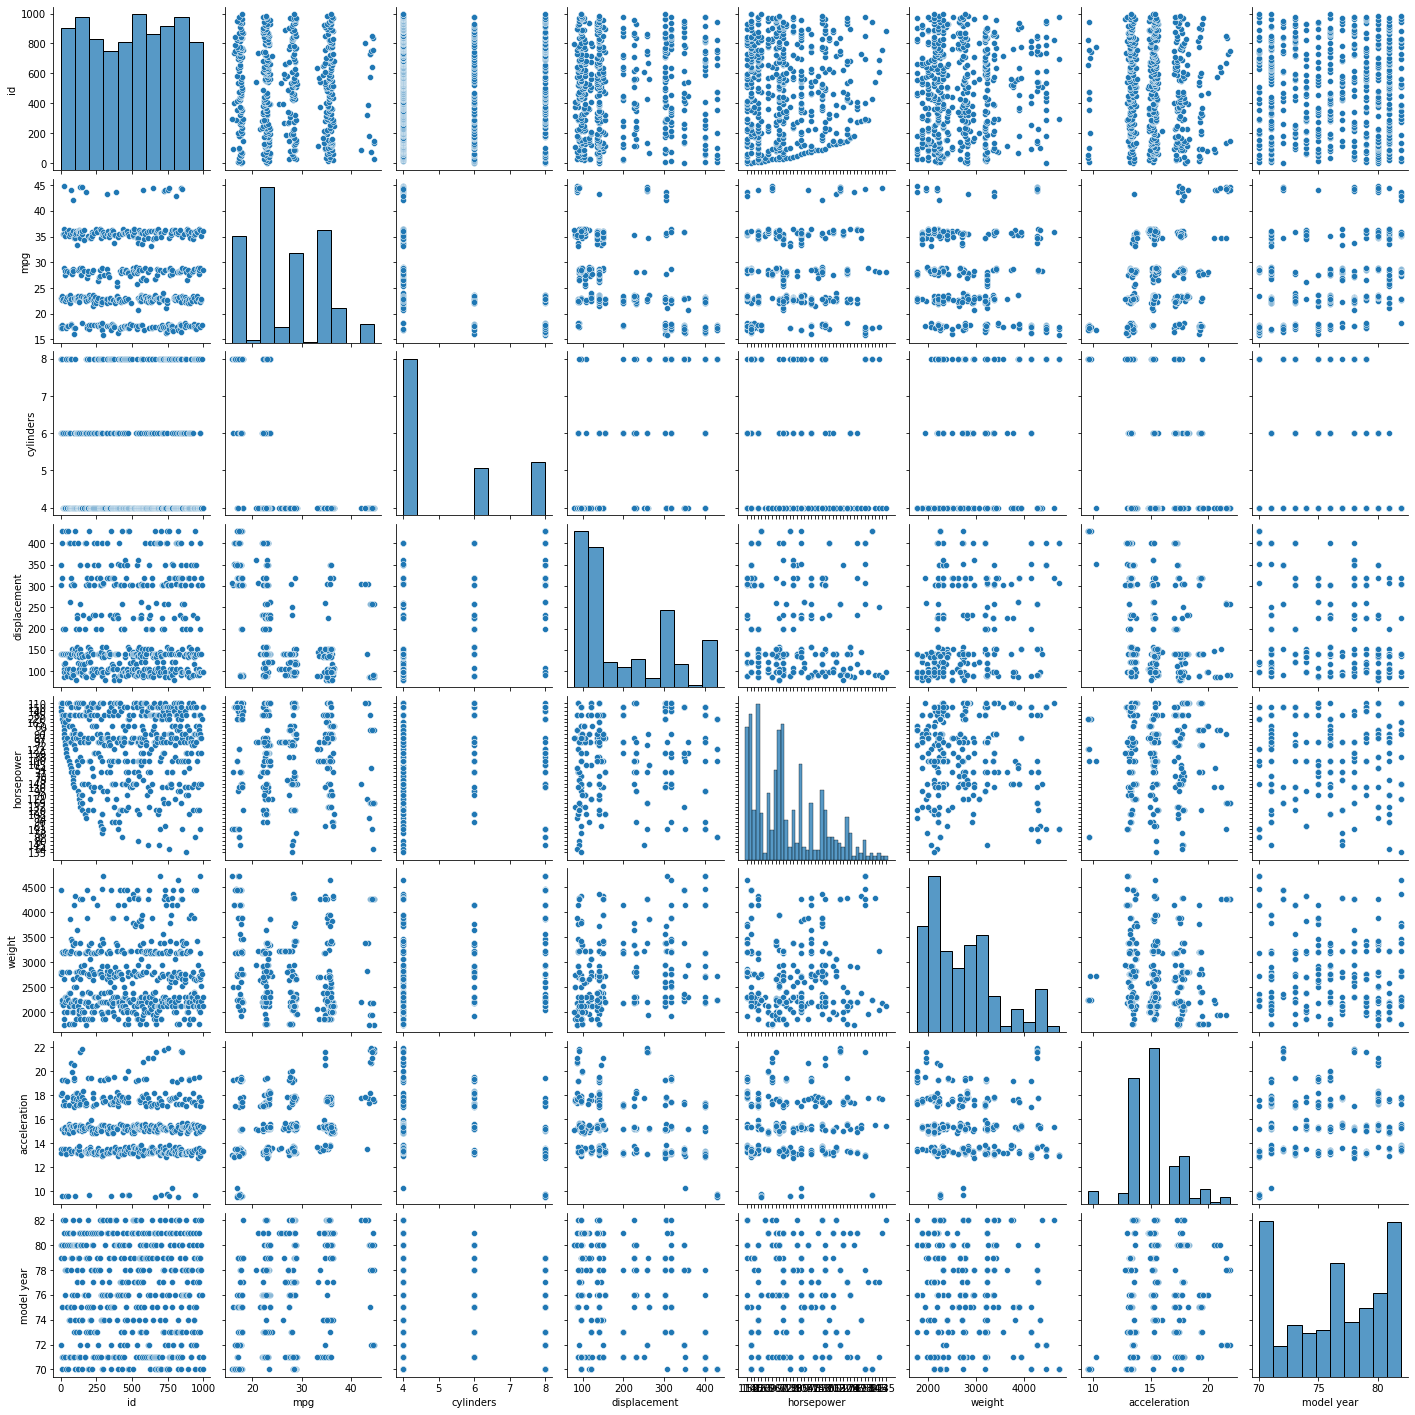

In [13]:
#各項目と価格の相関を確認
sns.pairplot(csv_train,vars=["id","mpg","cylinders","displacement","horsepower","weight","acceleration","model year"])

In [63]:
# XGBoostのライブラリのインポート
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [64]:
# xgboostモデルの作成
reg = xgb.XGBRegressor()

In [65]:
#horsepower の'?'を150に置き換え
csv_train['horsepower'] = csv_train['horsepower'].str.replace('?', '150')
csv_test['horsepower'] = csv_test['horsepower'].str.replace('?', '150')

In [66]:
#属性変換　varchar to int
csv_train['horsepower'] = csv_train['horsepower'].astype(int)
csv_train['cylinders'] = csv_train['cylinders'].astype(int)
csv_train['model year'] = csv_train['model year'].astype(int)
csv_train['origin'] = csv_train['origin'].astype(int)
csv_test['horsepower'] = csv_test['horsepower'].astype(int)
csv_test['cylinders'] = csv_test['cylinders'].astype(int)
csv_test['model year'] = csv_test['model year'].astype(int)
csv_test['origin'] = csv_test['origin'].astype(int)

In [67]:
#model year から最小値70をマイナスする
csv_train['model year'] = csv_train['model year']-70
csv_test['model year'] = csv_test['model year']-70

In [68]:
csv_train['horsepower'].dtype

dtype('int64')

In [69]:
# 説明変数、目的変数を格納 axis=1 x方向
X_train = csv_train.drop(['id','mpg','car name'], axis=1)
y_train = csv_train['mpg']
X_test = csv_test.drop(['id','car name'], axis=1)

In [70]:
# ハイパーパラメータ探索
#{'alpha': 0.0, 'colsample_bytree': 0.6, 'eta': 0.1, 'gamma': 0.1, 'lambda': 1.0, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.9} 0.8358415312594161
#[Parallel(n_jobs=1)]: Done 33600 out of 33600 | elapsed: 24.1min finished
#②{'alpha': 0.0, 'colsample_bytree': 0.4, 'eta': 0.1, 'gamma': 0.1, 'lambda': 1.0, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.9} 0.8453318693069807
#[Parallel(n_jobs=1)]: Done 7680 out of 7680 | elapsed:  5.6min finished
reg_cv = GridSearchCV(reg, {'max_depth': [7], 'min_child_weight': [4],'eta':[0.1],'colsample_bytree':[0.1,0.2,0.3,0.4,0.5,0.6,0.7],'alpha':[0.0],'subsample':[0.9,1.0],'gamma':[0.1],'lambda':[1.0]}, verbose=1)
reg_cv.fit(X_train, y_train)
print(reg_cv.best_params_, reg_cv.best_score_)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regre

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:07:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    2.4s finished


In [72]:
# ハイパーパラメータ探索結果
#①{'alpha': 0.0, 'colsample_bytree': 0.6, 'eta': 0.1, 'gamma': 0.1, 'lambda': 1.0, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.9} 0.8358415312594161
#[Parallel(n_jobs=1)]: Done 33600 out of 33600 | elapsed: 24.1min finished
#②{'alpha': 0.0, 'colsample_bytree': 0.4, 'eta': 0.1, 'gamma': 0.1, 'lambda': 1.0, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 0.9} 0.8453318693069807
#[Parallel(n_jobs=1)]: Done 7680 out of 7680 | elapsed:  5.6min finished
#③{'alpha': 0.0, 'colsample_bytree': 0.6, 'eta': 0.1, 'gamma': 0.1, 'lambda': 1.0, 'max_depth': 7, 'min_child_weight': 4, 'subsample': 1.0} 0.8495117676020616
#[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:    2.4s finished
# 改めて最適パラメータで学習
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(X_train, y_train)

[17:09:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=0.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, eta=0.1, gamma=0.1,
             importance_type='gain', lambda=1.0, learning_rate=0.1,
             max_delta_step=0, max_depth=7, min_child_weight=4, missing=None,
             n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1.0, verbosity=1)

In [73]:
# 学習データを使って予測
pred_train = reg.predict(X_train)

In [74]:
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,6,140,110,2815,17.977429,10,1
1,8,350,150,4456,13.514535,2,1
2,8,302,140,2774,13.209912,9,1
3,6,400,85,2190,15.196381,1,1
4,8,429,220,2245,9.621400,0,1


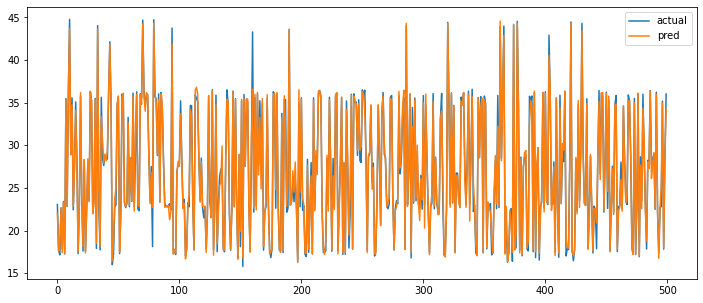

In [76]:
# 予測値が妥当か確認
train_value = y_train.values
_df = pd.DataFrame({'actual':train_value,'pred':pred_train})
_df.plot(figsize=(12,5))

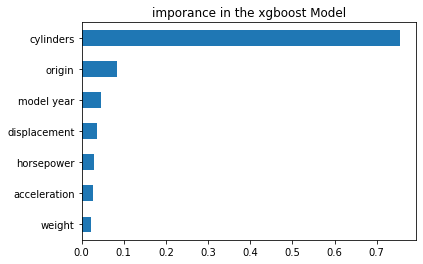

In [77]:
# feature importance のプロット
importances = pd.Series(reg.feature_importances_, index = X_train.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

In [78]:
# テストデータX_testに対し予測値の算出
pred_test = reg.predict(X_test)

In [79]:
csv_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CarFuel/test.csv', sep=",",engine="python")
# 結果を張り付け、ファイル出力
sample = pd.read_csv('/content/drive/My Drive/Colab Notebooks/CarFuel/sample_submit.csv',header=None)
sample[1] = pred_test
sample.to_csv("/content/drive/My Drive/Colab Notebooks/CarFuel/submit04.csv",index=None,header=None)